<a href="https://colab.research.google.com/github/MarkMechail/Student-Pass-Fail-Prediction-Based-on-Social-Aspects/blob/main/Student%20Pass/Fail%20Predicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

This dataset includes data about students, and its output is their final grade.

---

but we must remove G1 and G2 to be able to make a predicition on the final grade instead of it being a calculation.

In [ ]:
data = pd.read_csv('/content/student-mat1.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [ ]:
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


**Data Preprocessing**

In [ ]:
data = data.drop('G1', axis=1) #Dropping columns for First and Second semester grade since it wouldn't require prediction for the final grade if they existed
data = data.drop('G2', axis=1)
data['sex'].replace(['F','M'], [0,1], inplace=True)
data['school'].replace(['GP','MS'], [0,1], inplace=True)
data['address'].replace(['U','R'], [0,1], inplace=True)
data['famsize'].replace(['LE3','GT3'], [0,1], inplace=True)
data['Pstatus'].replace(['T','A'], [0,1], inplace=True)
data['Mjob'].replace(['teacher','health','services','at_home', 'other'], [0,1,2,3,4], inplace=True)
data['Fjob'].replace(['teacher','health','services','at_home', 'other'], [0,1,2,3,4], inplace=True)
data['reason'].replace(['home','reputation','course','other'], [0,1,2,3], inplace=True)
data['guardian'].replace(['mother','father','other'], [0,1,2], inplace=True)
data.replace(['yes','no'], [1,0], inplace=True) #Converting all yes to 1 and all no to 0
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      395 non-null    int64
 1   sex         395 non-null    int64
 2   age         395 non-null    int64
 3   address     395 non-null    int64
 4   famsize     395 non-null    int64
 5   Pstatus     395 non-null    int64
 6   Medu        395 non-null    int64
 7   Fedu        395 non-null    int64
 8   Mjob        395 non-null    int64
 9   Fjob        395 non-null    int64
 10  reason      395 non-null    int64
 11  guardian    395 non-null    int64
 12  traveltime  395 non-null    int64
 13  studytime   395 non-null    int64
 14  failures    395 non-null    int64
 15  schoolsup   395 non-null    int64
 16  famsup      395 non-null    int64
 17  paid        395 non-null    int64
 18  activities  395 non-null    int64
 19  nursery     395 non-null    int64
 20  higher      395 non-null    int6

In [ ]:
data['G3'] = data['G3'].apply(lambda x: 0 if x < 10 else 1) #Changing the final grade to 0 if below success and 1 if above; therefore, making the data classifiable into two classes
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
0,0,0,18,0,1,1,4,4,3,0,...,0,0,4,3,4,1,1,3,6,0
1,0,0,17,0,1,0,1,1,3,4,...,1,0,5,3,3,1,1,3,4,0
2,0,0,15,0,0,0,1,1,3,4,...,1,0,4,3,2,2,3,3,10,1
3,0,0,15,0,1,0,4,2,1,2,...,1,1,3,2,2,1,1,5,2,1
4,0,0,16,0,1,0,3,3,4,4,...,0,0,4,3,2,1,2,5,4,1


In [ ]:
predictors = data.drop('G3', axis=1) #Splitting Data into predictors and outcome for convenience
predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   school      395 non-null    int64
 1   sex         395 non-null    int64
 2   age         395 non-null    int64
 3   address     395 non-null    int64
 4   famsize     395 non-null    int64
 5   Pstatus     395 non-null    int64
 6   Medu        395 non-null    int64
 7   Fedu        395 non-null    int64
 8   Mjob        395 non-null    int64
 9   Fjob        395 non-null    int64
 10  reason      395 non-null    int64
 11  guardian    395 non-null    int64
 12  traveltime  395 non-null    int64
 13  studytime   395 non-null    int64
 14  failures    395 non-null    int64
 15  schoolsup   395 non-null    int64
 16  famsup      395 non-null    int64
 17  paid        395 non-null    int64
 18  activities  395 non-null    int64
 19  nursery     395 non-null    int64
 20  higher      395 non-null    int6

In [ ]:
outcome = data['G3']
outcome.info()

<class 'pandas.core.series.Series'>
RangeIndex: 395 entries, 0 to 394
Series name: G3
Non-Null Count  Dtype
--------------  -----
395 non-null    int64
dtypes: int64(1)
memory usage: 3.2 KB


**Splitting Data**

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(predictors, outcome, test_size = 0.2, random_state=0) #Performing train test split

In [ ]:
x_train.shape #ensuring data was split correctly.

(316, 30)

In [ ]:
x_test.shape

(79, 30)

In [ ]:
y_train.shape

(316,)

In [ ]:
y_test.shape

(79,)

**Building standard Random Forest Classifier**

In [ ]:
model = RandomForestClassifier(n_estimators = 100)

In [ ]:
model.fit(x_train,y_train)

RandomForestClassifier()

In [57]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues,
                xticklabels=['Fail', 'Succeed'],
                yticklabels=['Fail', 'Succeed'])
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

**Evaluation and Confusion Matrix of standard Random Forest Classifier Model**

In [ ]:
predicitions = model.predict(x_test)
acc = accuracy_score(y_test,predicitions)
precision = precision_score(y_test,predicitions)
recall = recall_score(y_test,predicitions)
f1 = f1_score(y_test,predicitions)
print(f"Accuracy: {acc}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}")

Accuracy: 0.7088607594936709
Precision: 0.6911764705882353
Recall: 0.9591836734693877
F1: 0.8034188034188035


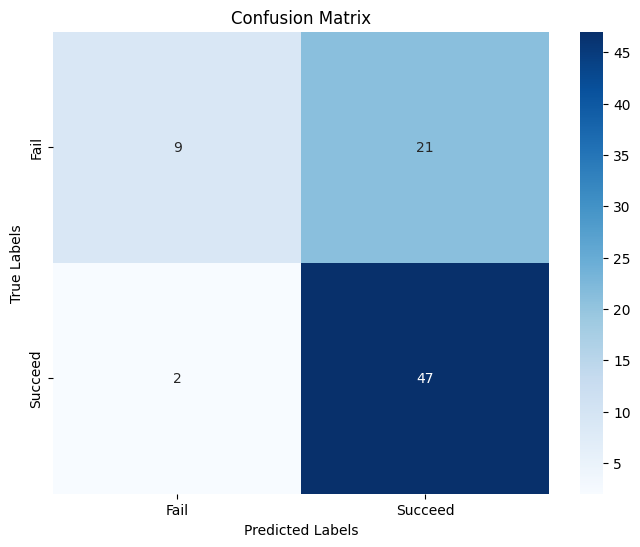

In [60]:
plot_confusion_matrix(y_test, predicitions)

**Finding best parameters (Hyper Parameters) using grid search**

In [61]:
grid = {
    'n_estimators': [100,150,200,300],
    'max_depth': [None, 2, 4, 8],
    'min_samples_leaf': [1,2,3,4],
    'min_samples_split': [1,2,5,8]
}
modelH = RandomForestClassifier(random_state=20)
gSearch = GridSearchCV(modelH, grid, cv=5, scoring='accuracy')
gSearch.fit(x_train, y_train)
bestParameters = gSearch.best_params_
print(bestParameters)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
320 fits failed out of a total of 1280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}


**Running Model using Hyperparameters, Evaluating and drawing Confusion Matrix**

In [64]:
bClassifier = gSearch.best_estimator_
predicitions2 = bClassifier.predict(x_test)
acc = accuracy_score(y_test,predicitions2)
precision = precision_score(y_test,predicitions2)
recall = recall_score(y_test,predicitions2)
f1 = f1_score(y_test,predicitions2)
print(f"Accuracy: {acc}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}")

Accuracy: 0.6582278481012658
Precision: 0.6617647058823529
Recall: 0.9183673469387755
F1: 0.7692307692307692


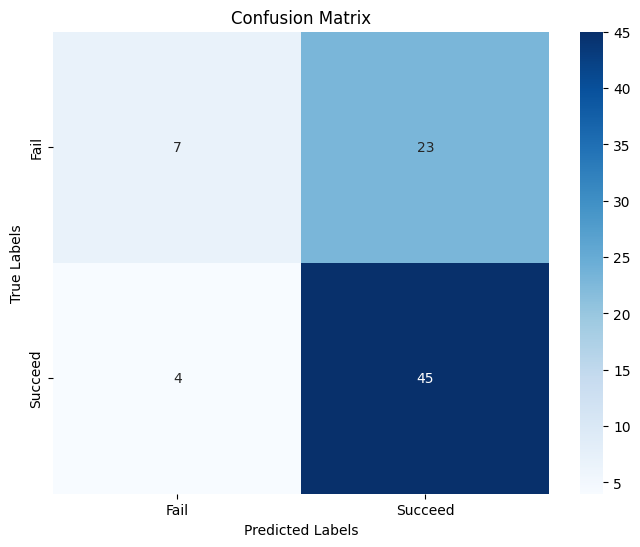

In [65]:
plot_confusion_matrix(y_test, predicitions2)

**Setting up deap library for Genetic Algorithm**

In [ ]:
!pip install deap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 2.5 MB/s eta 0:00:00


**Creating array with all features for convenience**

In [67]:
print(predictors.head(0))
allFeatures = ['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
len(allFeatures)

Empty DataFrame
Columns: [school, sex, age, address, famsize, Pstatus, Medu, Fedu, Mjob, Fjob, reason, guardian, traveltime, studytime, failures, schoolsup, famsup, paid, activities, nursery, higher, internet, romantic, famrel, freetime, goout, Dalc, Walc, health, absences]
Index: []

[0 rows x 30 columns]


30

**Using Genetic Algorithm to select the best Features and creating fittness function using Random Forest Classifier**

In [51]:
import random
from deap import base, creator, tools, algorithms

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Define the fitness function
def evaluate(individual):
    # Create a mask from the individual
    mask = np.array(individual, dtype=bool)
    selected_features = [feature for feature, select in zip(allFeatures, mask) if select]

    # Select the features from the training and test set
    x_train_selected = x_train.loc[:, mask]
    x_test_selected = x_test.loc[:, mask]

    # Train a classifier
    clf = RandomForestClassifier(n_estimators=100)
    clf.fit(x_train_selected, y_train)

    # Evaluate the classifier
    y_pred = clf.predict(x_test_selected)
    return accuracy_score(y_test, y_pred),

# Define the genetic algorithm parameters
n_gen = 100  # Number of generations
pop_size = 20  # Population size
n_features = len(allFeatures)  # Number of features
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Create the population and run the genetic algorithm
pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=n_gen, stats=stats, halloffame=hof, verbose=True)

# Get the best individual
best_individual = hof[0]
best_features = [feature for feature, select in zip(allFeatures, best_individual) if select]

print("Best individual:", best_individual)
print("Best features:", best_features)


gen	nevals	avg     	min    	max     
0  	20    	0.641772	0.56962	0.734177
1  	11    	0.675316	0.620253	0.734177
2  	9     	0.689873	0.594937	0.721519
3  	7     	0.702532	0.632911	0.721519
4  	14    	0.701899	0.594937	0.734177
5  	8     	0.711392	0.683544	0.734177
6  	15    	0.70443 	0.594937	0.734177
7  	18    	0.709494	0.670886	0.734177
8  	8     	0.717089	0.696203	0.734177
9  	10    	0.718354	0.670886	0.734177
10 	8     	0.720886	0.696203	0.734177
11 	9     	0.721519	0.696203	0.734177
12 	11    	0.721519	0.683544	0.734177
13 	8     	0.71962 	0.64557 	0.746835
14 	9     	0.725949	0.670886	0.746835
15 	8     	0.732911	0.696203	0.746835
16 	15    	0.725949	0.696203	0.746835
17 	10    	0.724684	0.632911	0.759494
18 	12    	0.720253	0.632911	0.759494
19 	12    	0.726582	0.658228	0.759494
20 	10    	0.737342	0.708861	0.759494
21 	13    	0.731013	0.670886	0.759494
22 	11    	0.731646	0.683544	0.759494
23 	12    	0.733544	0.683544	0.759494
24 	9     	0.740506	0.696203	0.759494
25 	13    	0.7

**Defining data after Feature Selection**

In [52]:
opt_x_train = x_train[best_features]
opt_x_test = x_test[best_features]

**Training model on selected Features only**

In [53]:
optimizedModel = RandomForestClassifier(n_estimators=100)
optimizedModel.fit(opt_x_train, y_train)

RandomForestClassifier()

**Evaluating Model and drawing Confusion Matrix**

In [54]:
optPredicitions = optimizedModel.predict(opt_x_test)
acc = accuracy_score(y_test,optPredicitions)
precision = precision_score(y_test,optPredicitions)
recall = recall_score(y_test,optPredicitions)
f1 = f1_score(y_test,optPredicitions)
print(f"Accuracy: {acc}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}")

Accuracy: 0.7341772151898734
Precision: 0.7121212121212122
Recall: 0.9591836734693877
F1: 0.817391304347826


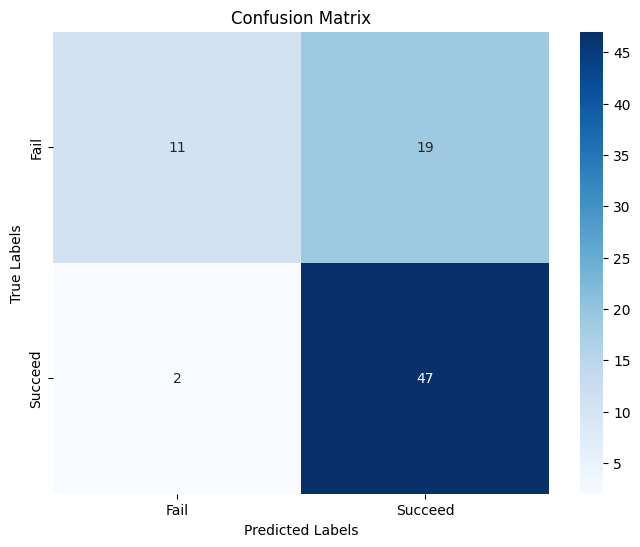

In [55]:
plot_confusion_matrix(y_test, optPredicitions)